# Paper figure: Case study

In [66]:
from datetime import datetime
from itertools import product
from pathlib import Path
from typing import Any
import seaborn as sns 
import joblib
# import keras
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
# import plotly.express as px
# import plotly.graph_objects as go
# import streamlit as st
# import tensorflow as tf
import xarray as xr
from sklearn import metrics
# from sklearn.ensemble import RandomForestClassifier

## Get your Constants

In [67]:
PHASE_MAP = {
    0: "clear",
    1: "liquid",
    2: "ice",
    3: "mixed",
    4: "drizzle",
    5: "liq_driz",
    6: "rain",
    7: "snow",
    8: "unknown",
}

# Updated PHASE_MAP to exclude 'clear' and 'unknown'
PHASE_MAP_small = {
    1: "liquid",
    2: "ice",
    3: "mixed",
    4: "drizzle",
    5: "liq_driz",
    6: "rain",
    7: "snow"
}

In [68]:
_cblind = sns.color_palette("colorblind")

custom_colors = [
    "white",  # clear (white)
    _cblind[2],  # liquid (dark purple from viridis)
    _cblind[0],  # ice (blue from viridis)
    _cblind[3],  # mixed (greenish-blue from viridis)
    _cblind[9],  # drizzle (light green from viridis)
    _cblind[6],  # liq_driz (yellow from viridis)
    _cblind[8],  # rain (brighter yellow)
    _cblind[5],  # snow (orange-yellow)
    "black",  # unknown (grey)
]

## Figure Code called as functions

In [71]:
def create_timeseries(variable_name, axs, ds, PHASE_MAP, custom_colors):
    """
    Creates a timeseries plot along with a confusion matrix and custom colorbar.
    
    Parameters:
    axs (matplotlib.axes.Axes): The axis to plot the figure on.
    ds (xarray.Dataset): The dataset containing the timeseries data.
    PHASE_MAP (dict): Dictionary mapping the phase labels to categories.
    custom_colors (list): Custom colors to apply to different phases in the timeseries.
    """
    # Extract phase values and labels
    phase_values = list(PHASE_MAP.keys())
    phase_labels = list(PHASE_MAP.values())

    # Define the integer range for levels
    min_val = int(ds[variable_name].min().values)
    max_val = int(ds[variable_name].max().values)

    # Create a colormap with distinct colors for each integer value
    cmap = mcolors.ListedColormap(custom_colors)

    # Plot the timeseries with the colormap
    plot = ds[variable_name].transpose().plot(ax=axs, cmap=cmap, 
                                                    levels=np.arange(len(phase_values)+1), 
                                                    add_colorbar=False)

    # Add a colorbar with custom ticks and labels
    cbar = plt.colorbar(plot, ax=axs, ticks=phase_values)
    cbar.set_ticklabels(phase_labels)  # Set phase names as labels for each tick
    cbar.ax.tick_params(labelsize=8)

    # Add labels and title for the timeseries plot
    axs.set_xlabel('', fontsize=12)
    

    if variable_name == 'cloud_phase_mplgr':
        axs.set_title('Ground Truth VAP', fontsize=16)
        axs.set_ylabel('\n Height [km]', fontsize=12)
    if 'rf' in variable_name:
        axs.set_title('RF', fontsize=16)
        axs.set_ylabel('', fontsize=12)
    if 'cnn_20240501_090456' in variable_name:
        axs.set_title('CNN', fontsize=16)
        axs.set_ylabel('', fontsize=12)
    if 'cnn_20240429_213223' in variable_name:
        axs.set_title('CNN with 2D \n Spatial Dropouts', fontsize=16)
        axs.set_ylabel('', fontsize=12)
    if 'mlp' in variable_name:
        axs.set_title('MLP', fontsize=16)
        axs.set_ylabel('', fontsize=12)
    
    axs.tick_params(axis='x', rotation=45, labelsize=10)
    axs.tick_params(axis='y', labelsize=10)
    axs.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
# Example usage:
# fig, axs = plt.subplots(figsize=(10, 6))
# create_timeseries('cnn_20240429_213223',axs, ds, PHASE_MAP, custom_colors)
# plt.show()

In [72]:
def create_confidence_timeseries(variable_name, axs, ds):

    # Create a new xarray DataArray using the max_phase_values
    confidence_da = xr.DataArray(
        np.max(ds[variable_name].values, axis=2) * 100,  # Data
        coords=[ds.time.values, ds.height.values],  # Coordinates (time, height)
        dims=["time", "height"],  # Dimension names
        name="Confidence Score [%]",  # Optional: name of the DataArray
    )

    plot = confidence_da.T.plot(ax=axs, vmin=0, vmax=100, add_colorbar=False)

    # Adjust font sizes for title, labels, ticks, and colorbar
    #if variable_name == 'cnn_20240429_213223_confidence':
    axs.set_title('Confidence Score [%]', fontsize=14)  # Title font size
    axs.set_xlabel('', fontsize=14)  # X-axis label font size
    axs.set_ylabel('Height [km]', fontsize=12)  # Y-axis label font size

    # Adjust tick label sizes
    axs.tick_params(axis='both', labelsize=12)  # Axis tick labels font size

    # Adjust colorbar font size
    cbar = plt.colorbar(plot, ax=axs)
    cbar.ax.tick_params(labelsize=12)  # Colorbar tick label size
    # cbar.set_label(label='Confidence Score [%]',fontsize=14)

    axs.tick_params(axis='x', rotation=45, labelsize=10)
    axs.tick_params(axis='y', labelsize=10)
    axs.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    masked_flag = np.ma.masked_where(ds.cloud_flag.T == 1, ds.cloud_flag.T)

    # Plot using contourf for areas where the flag is 0 (masked areas are not filled)
    plot_overlay = axs.contourf(ds.time, ds.height, masked_flag, levels=[0, 0.5], colors=['white'], extend='both')


In [73]:
def create_matrix(variable_name, axs, ds, PHASE_MAP):
    """
    Create a confusion matrix with accuracy and IoU metrics.
    
    Parameters:
    axs (matplotlib.axes.Axes): The axis to plot the figure on.
    ds (xarray.Dataset): The dataset containing the true and predicted labels.
    PHASE_MAP (dict): Dictionary mapping the phase labels to categories.
    """
    # Convert xarray data to pandas series
    y_true = ds["cloud_phase_mplgr"].to_series()
    y_pred = ds[variable_name].to_series()

    # Remap predictions and ground truth to categorical labels
    y_pred = y_pred.reset_index(drop=True).map(PHASE_MAP).astype("category")
    y_true = y_true.reset_index(drop=True).map(PHASE_MAP).astype("category")
    
    # Filter out "unknown" and "clear" categories before comparing
    valid_labels = list(PHASE_MAP.values())  # Only include labels we want to keep
    valid_idx = y_true.isin(valid_labels) & y_pred.isin(valid_labels)
    
    # Apply the filter to both y_true and y_pred to ensure the same shape
    y_true = y_true[valid_idx]
    y_pred = y_pred[valid_idx]

    # Check if lengths match after filtering
    if len(y_true) != len(y_pred):
        raise ValueError(f"After filtering, y_true and y_pred have different lengths: {len(y_true)} vs {len(y_pred)}")
    
    # Calculate accuracy and mean IoU
    accuracy = metrics.accuracy_score(y_true=y_true, y_pred=y_pred)
    iou = np.mean(metrics.jaccard_score(y_true=y_true, y_pred=y_pred, average=None))

    # Set font size for the plot
    font = {'size': 5}
    plt.rc('font', **font)

    # Generate and plot the confusion matrix
    cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        labels=valid_labels,
        ax=axs,
        colorbar=False,
        normalize="true"
    )

    # Set title and labels for the plot
    axs.set_title(f"Accuracy={100*accuracy:.3f}%, Mean IoU={iou:.3f}", fontsize=10)
    axs.set_ylabel("Ground Truth", fontsize=14)
    #if 'rf' in variable_name:
    axs.set_xlabel("Model Classification", fontsize=14)
    #else:
    #    axs.set_xlabel("")

    # Rotate x-tick labels and set fontsize using tick_params
    axs.tick_params(axis='x', rotation=45, labelsize=7)
    axs.tick_params(axis='y', labelsize=7)

# Example usage:
# fig, axs = plt.subplots(figsize=(6, 6))
# create_matrix('cnn_20240429_213223', axs, ds, PHASE_MAP)
# plt.show()


In [74]:
def create_histogram(variable_name, axs, ds, PHASE_MAP, custom_colors):
    """
    Creates a histogram of CNN phase data, excluding clear pixels (phase 0).
    
    Parameters:
    axs (matplotlib.axes.Axes): The axis to plot the histogram on.
    ds (xarray.Dataset): The dataset containing the CNN phase data.
    PHASE_MAP (dict): Dictionary mapping phase integers to phase names.
    custom_colors (list): Custom colors to apply to different phases in the histogram.
    """
    # Extract the data from the DataArray
    data = ds[variable_name].values.flatten()

    # Mask out the "clear" pixels (corresponding to phase 0)
    non_clear_data = data[data != 0]

    # Create the histogram data for non-clear phases
    bins = np.arange(0.5, len(PHASE_MAP), 1)  # Exclude bin for 'clear'
    hist, bin_edges = np.histogram(non_clear_data, bins=bins)

    # Convert frequency counts to percentages (ignoring 'clear')
    total_count = hist.sum()
    percentages = (hist / total_count) * 100

    # Plot the histogram with custom colors and percentage values (excluding 'clear')
    axs.bar(
        range(1, len(PHASE_MAP)),  # Phases 1 and beyond (excluding clear)
        percentages,
        color=custom_colors[1:],  # Exclude the color for 'clear'
        tick_label=list(PHASE_MAP.values())[1:]  # Exclude 'clear' from tick labels
    #    tick_label = ['','','','','','','','']
    )

    # Set limits for the percentage axis (0 to 100)
    axs.set_ylim(0, 100)
    
    # Add labels and title
    # axs.set_ylabel('Phase Classification', fontsize=12)
    # if 'rf' in variable_name:
    axs.set_ylabel('\n Percentage (%)', fontsize=12)
    # if variable_name == 'cloud_phase_mplgr':
    axs.set_title('Phase Class Histogram', fontsize=14)
    axs.tick_params(axis='x', labelsize=8)
    axs.tick_params(axis='y', labelsize=10)
    axs.tick_params(axis='y')#, labelleft=False)# left=False
    axs.tick_params(axis='x', rotation=45)
    axs.grid(axis='y')


# Example usage:
# fig, axs = plt.subplots(figsize=(8, 6))
# create_histogram('cnn_20240429_213223',axs, ds, PHASE_MAP, custom_colors)
# plt.show()


# Fill in Figure SubPlots

Figure 3: case study of rf, mlp, and cnn from NSA, August 31, 2021

Figure 7: case study of rf, mlp, and cnn from ANX, cold air outbreak feb 25, 2020, but continue to look for better cases
remove the matrix and confidence time series to unclutter this figure

Figure 8: drop out study of rf, mlp, cnn, and cnn w/ dropouts, use september 5th case NSA

Figure 9: show how the cnn with dropouts responds to dropping out of different variables, use september 5th at NSA

Another good case to use is August 15,2021 from NSA

In [97]:
# Define the positions for each subplot
# The positions are defined as [left, bottom, width, height]
heights = 0.2
hist_pos = 0.33
conf_pos = .5
matrix_pos = 0.71

height = 0.13
width = 0.14

start_height = 0.15

col1 = 0.1
col2 = 0.3
col3 = 0.5
col4 = 0.7
positions = [
    # Row 1 Time Series
    [col1, start_height +  heights * 3, width, height],   # Subplot 0
    [col2, start_height +  heights * 3, width, height],   # Subplot 1
    [col3, start_height +  heights * 3, width, height],   # Subplot 2
    [col4, start_height +  heights * 3, width, height],   # Subplot 3
    # Row 2 Histogram
    [col1, start_height +  heights * 2, width, height],  # Subplot 4
    [col2, start_height +  heights * 2, width, height],  # Subplot 5
    [col3, start_height +  heights * 2, width, height],  # Subplot 6
    [col4, start_height +  heights * 2, width, height],  # Subplot 7
    # Row 3 Confidence Time Series
    #[col1, start_height +  heights * 1, width, height],   
    [col2, start_height +  heights * 1, width, height],   # Subplot 8
    [col3, start_height +  heights * 1, width, height],  # Subplot 9
    [col4, start_height +  heights * 1, width, height],   # Subplot 10
    # Row 4 Matrix
    #[col1, start_height, width, height],  
    [col2, start_height, width, height],  # Subplot 11
    [col3, start_height, width, height],  # Subplot 12
    [col4, start_height, width, height],  # Subplot 13
]

#### Figure 3 a&b



In [88]:
BASE_PATH = Path("/home/levin/github/ml-for-cloudphase-amt-2024/src/processing/data/predictions/")
FILE_GLOB = "nsathermocldphaseC1.c1.20210831.000000.nc"

# Construct the full file path
file_path = BASE_PATH / FILE_GLOB

# Open the NetCDF file with xarray
ds = xr.open_dataset(file_path)

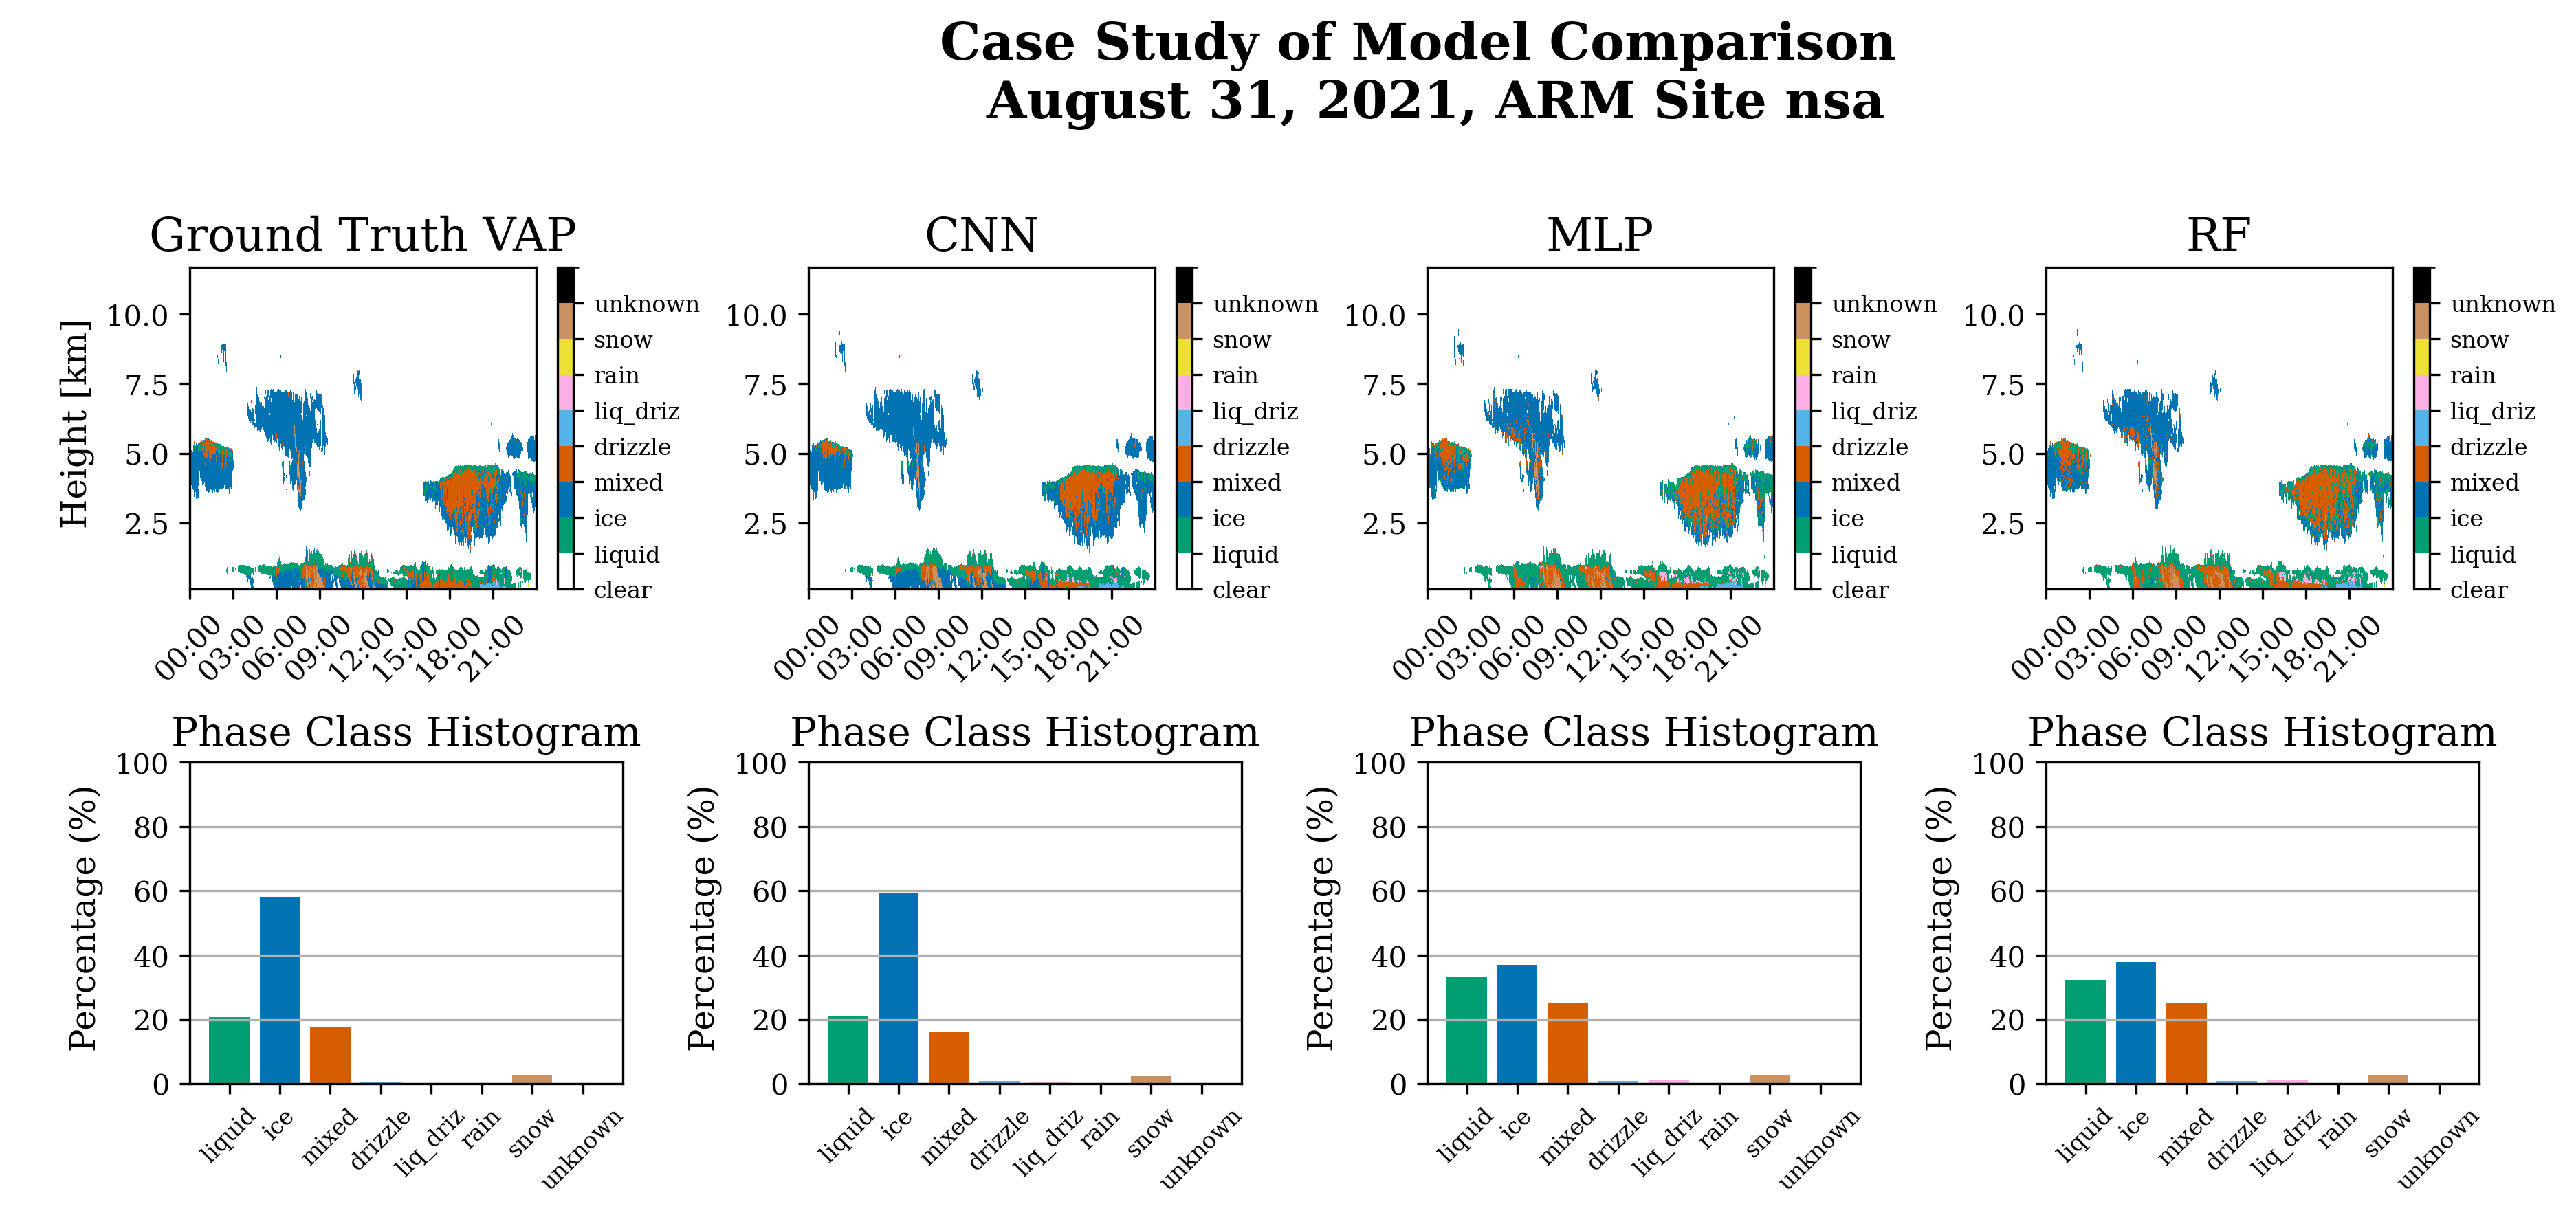

In [89]:

with plt.style.context("style.mplstyle"):
    # Create a figure
    fig = plt.figure(figsize=(15, 12))

    plt.suptitle('Case Study of Model Comparison \n ' + pd.to_datetime(ds.time[0].values).strftime('%B %d, %Y') + ', ARM Site ' + FILE_GLOB[0:3], fontsize=18, fontweight='bold')

    # Create subplots
    axs = []
    for pos in positions[0:8]:
        ax = fig.add_axes(pos)  # Create an axes at the specified position
        axs.append(ax)

    # VAP Data
    create_timeseries('cloud_phase_mplgr',axs[0], ds, PHASE_MAP, custom_colors)
    create_histogram('cloud_phase_mplgr',axs[4], ds, PHASE_MAP, custom_colors)
    # CNN
    create_timeseries('cnn_20240501_090456',axs[1], ds, PHASE_MAP, custom_colors)
    create_histogram('cnn_20240501_090456',axs[5], ds, PHASE_MAP, custom_colors)
    # create_confidence_timeseries('cnn_20240501_090456_confidence', axs[8], ds)
    # create_matrix('cnn_20240501_090456',axs[11], ds, PHASE_MAP_small)
    # MLP
    create_timeseries('mlp_1600k_20240514_052837',axs[2], ds, PHASE_MAP, custom_colors)
    create_histogram('mlp_1600k_20240514_052837',axs[6], ds, PHASE_MAP, custom_colors)
    # create_confidence_timeseries('mlp_1600k_20240514_052837_confidence', axs[9], ds)
    # create_matrix('mlp_1600k_20240514_052837',axs[12], ds, PHASE_MAP_small)
    # RF
    create_timeseries('rf_1600k_20240514_033147',axs[3], ds, PHASE_MAP, custom_colors)
    create_histogram('rf_1600k_20240514_033147',axs[7], ds, PHASE_MAP, custom_colors)
    # create_confidence_timeseries('rf_1600k_20240514_033147_confidence', axs[10], ds)
    # create_matrix('rf_1600k_20240514_033147',axs[13], ds, PHASE_MAP_small)

    fig.savefig('figure_3a.png')   
    plt.show() 


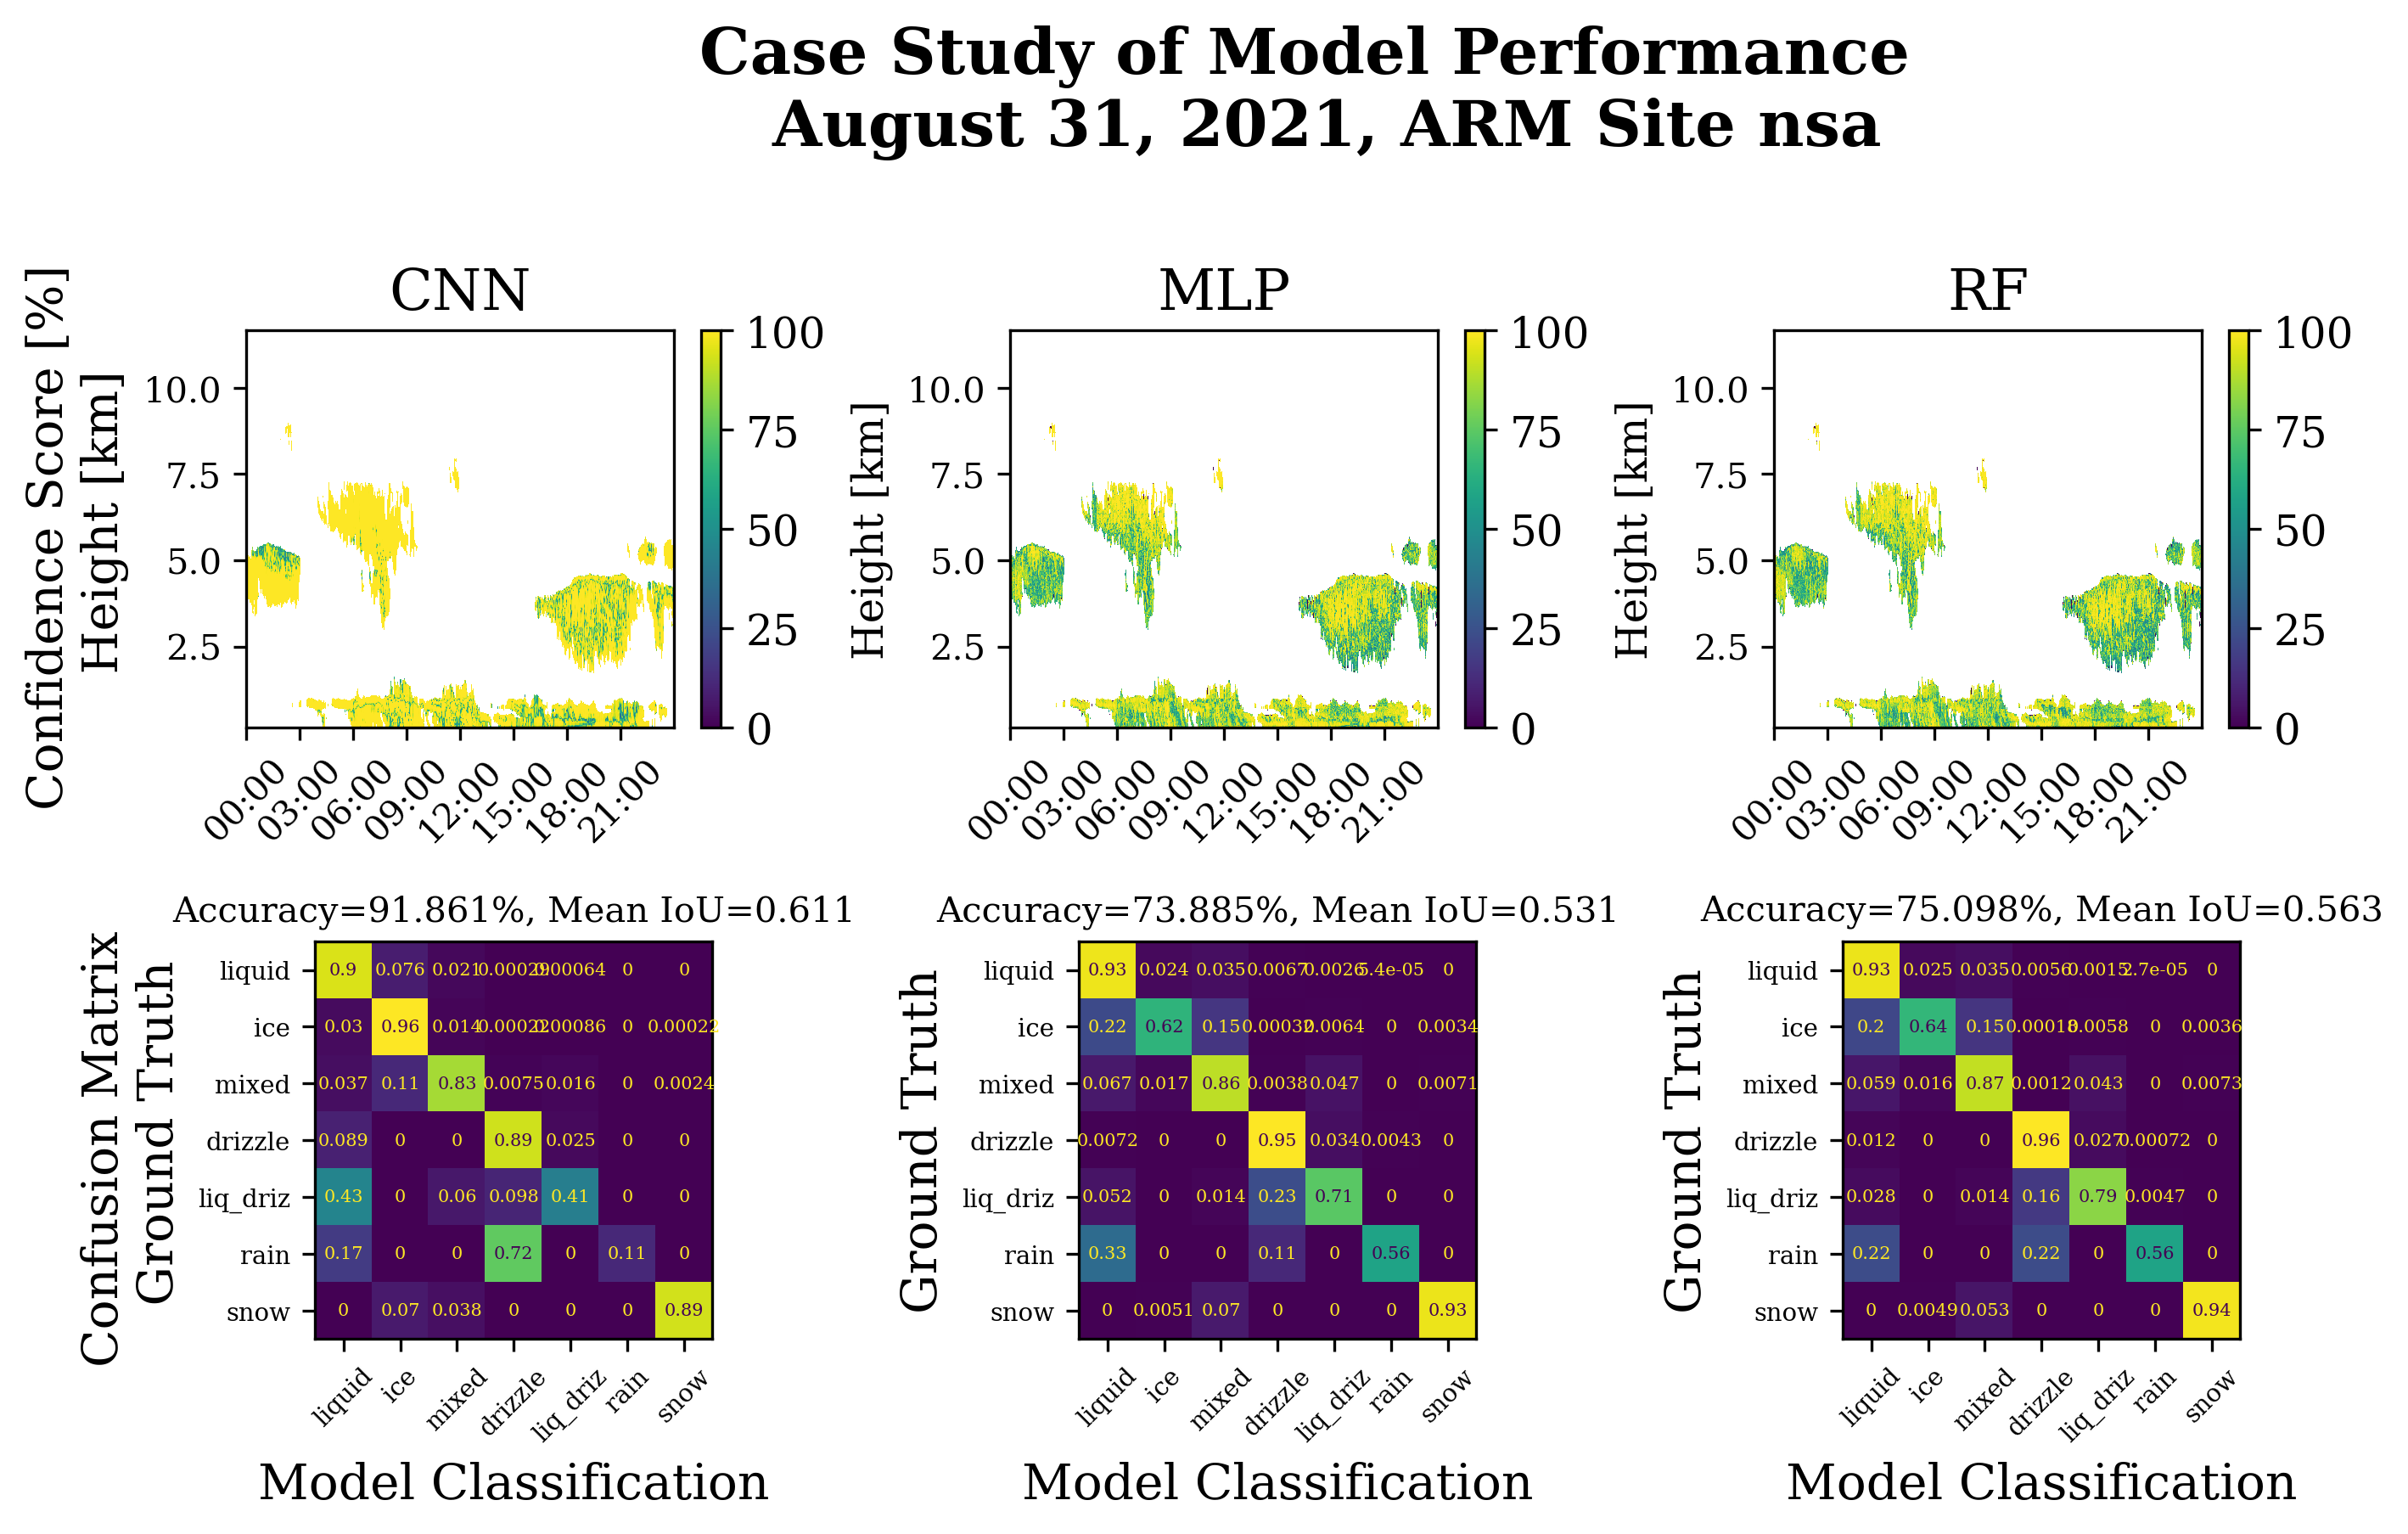

In [94]:
shift = 0.12
positions2 = [
    # Row 1 Confidence Score Time Series
    [col1 + shift, start_height +  heights * 3, width, height],   # Subplot 0
    [col2 + shift, start_height +  heights * 3, width, height],   # Subplot 1
    [col3 + shift, start_height +  heights * 3, width, height],   # Subplot 2
    # Row 2 Matrix
    [col1 + shift, start_height +  heights * 2, width, height],  # Subplot 3
    [col2 + shift, start_height +  heights * 2, width, height],  # Subplot 4
    [col3 + shift, start_height +  heights * 2, width, height],  # Subplot 5
    ] 

with plt.style.context("style.mplstyle"):
    # Create a figure
    fig = plt.figure(figsize=(15, 12))

    plt.suptitle('Case Study of Model Performance \n ' + pd.to_datetime(ds.time[0].values).strftime('%B %d, %Y') + ', ARM Site ' + FILE_GLOB[0:3], fontsize=18, fontweight='bold')

    # Create subplots
    axs = []
    for pos in positions2:
        ax = fig.add_axes(pos)  # Create an axes at the specified position
        axs.append(ax)

    # CNN

    create_confidence_timeseries('cnn_20240501_090456_confidence', axs[0], ds)
    create_matrix('cnn_20240501_090456',axs[3], ds, PHASE_MAP_small)
    # MLP

    create_confidence_timeseries('mlp_1600k_20240514_052837_confidence', axs[1], ds)
    create_matrix('mlp_1600k_20240514_052837',axs[4], ds, PHASE_MAP_small)
    # RF

    create_confidence_timeseries('rf_1600k_20240514_033147_confidence', axs[2], ds)
    create_matrix('rf_1600k_20240514_033147',axs[5], ds, PHASE_MAP_small)

    axs[0].set_title('CNN', fontsize = 16)
    axs[1].set_title('MLP', fontsize = 16)
    axs[2].set_title('RF', fontsize = 16)
    axs[0].set_ylabel('Confidence Score [%] \n Height [km]', fontsize = 14)
    axs[3].set_ylabel('Confusion Matrix \n Ground Truth', fontsize = 14)
   

    fig.savefig('figure_3b.png')   
    plt.show() 


### Figure 7

In [79]:
FILE_GLOB = "anxthermocldphaseM1.c1.20200225.000000.nc"

# Construct the full file path
file_path = BASE_PATH / FILE_GLOB

# Open the NetCDF file with xarray
ds = xr.open_dataset(file_path)

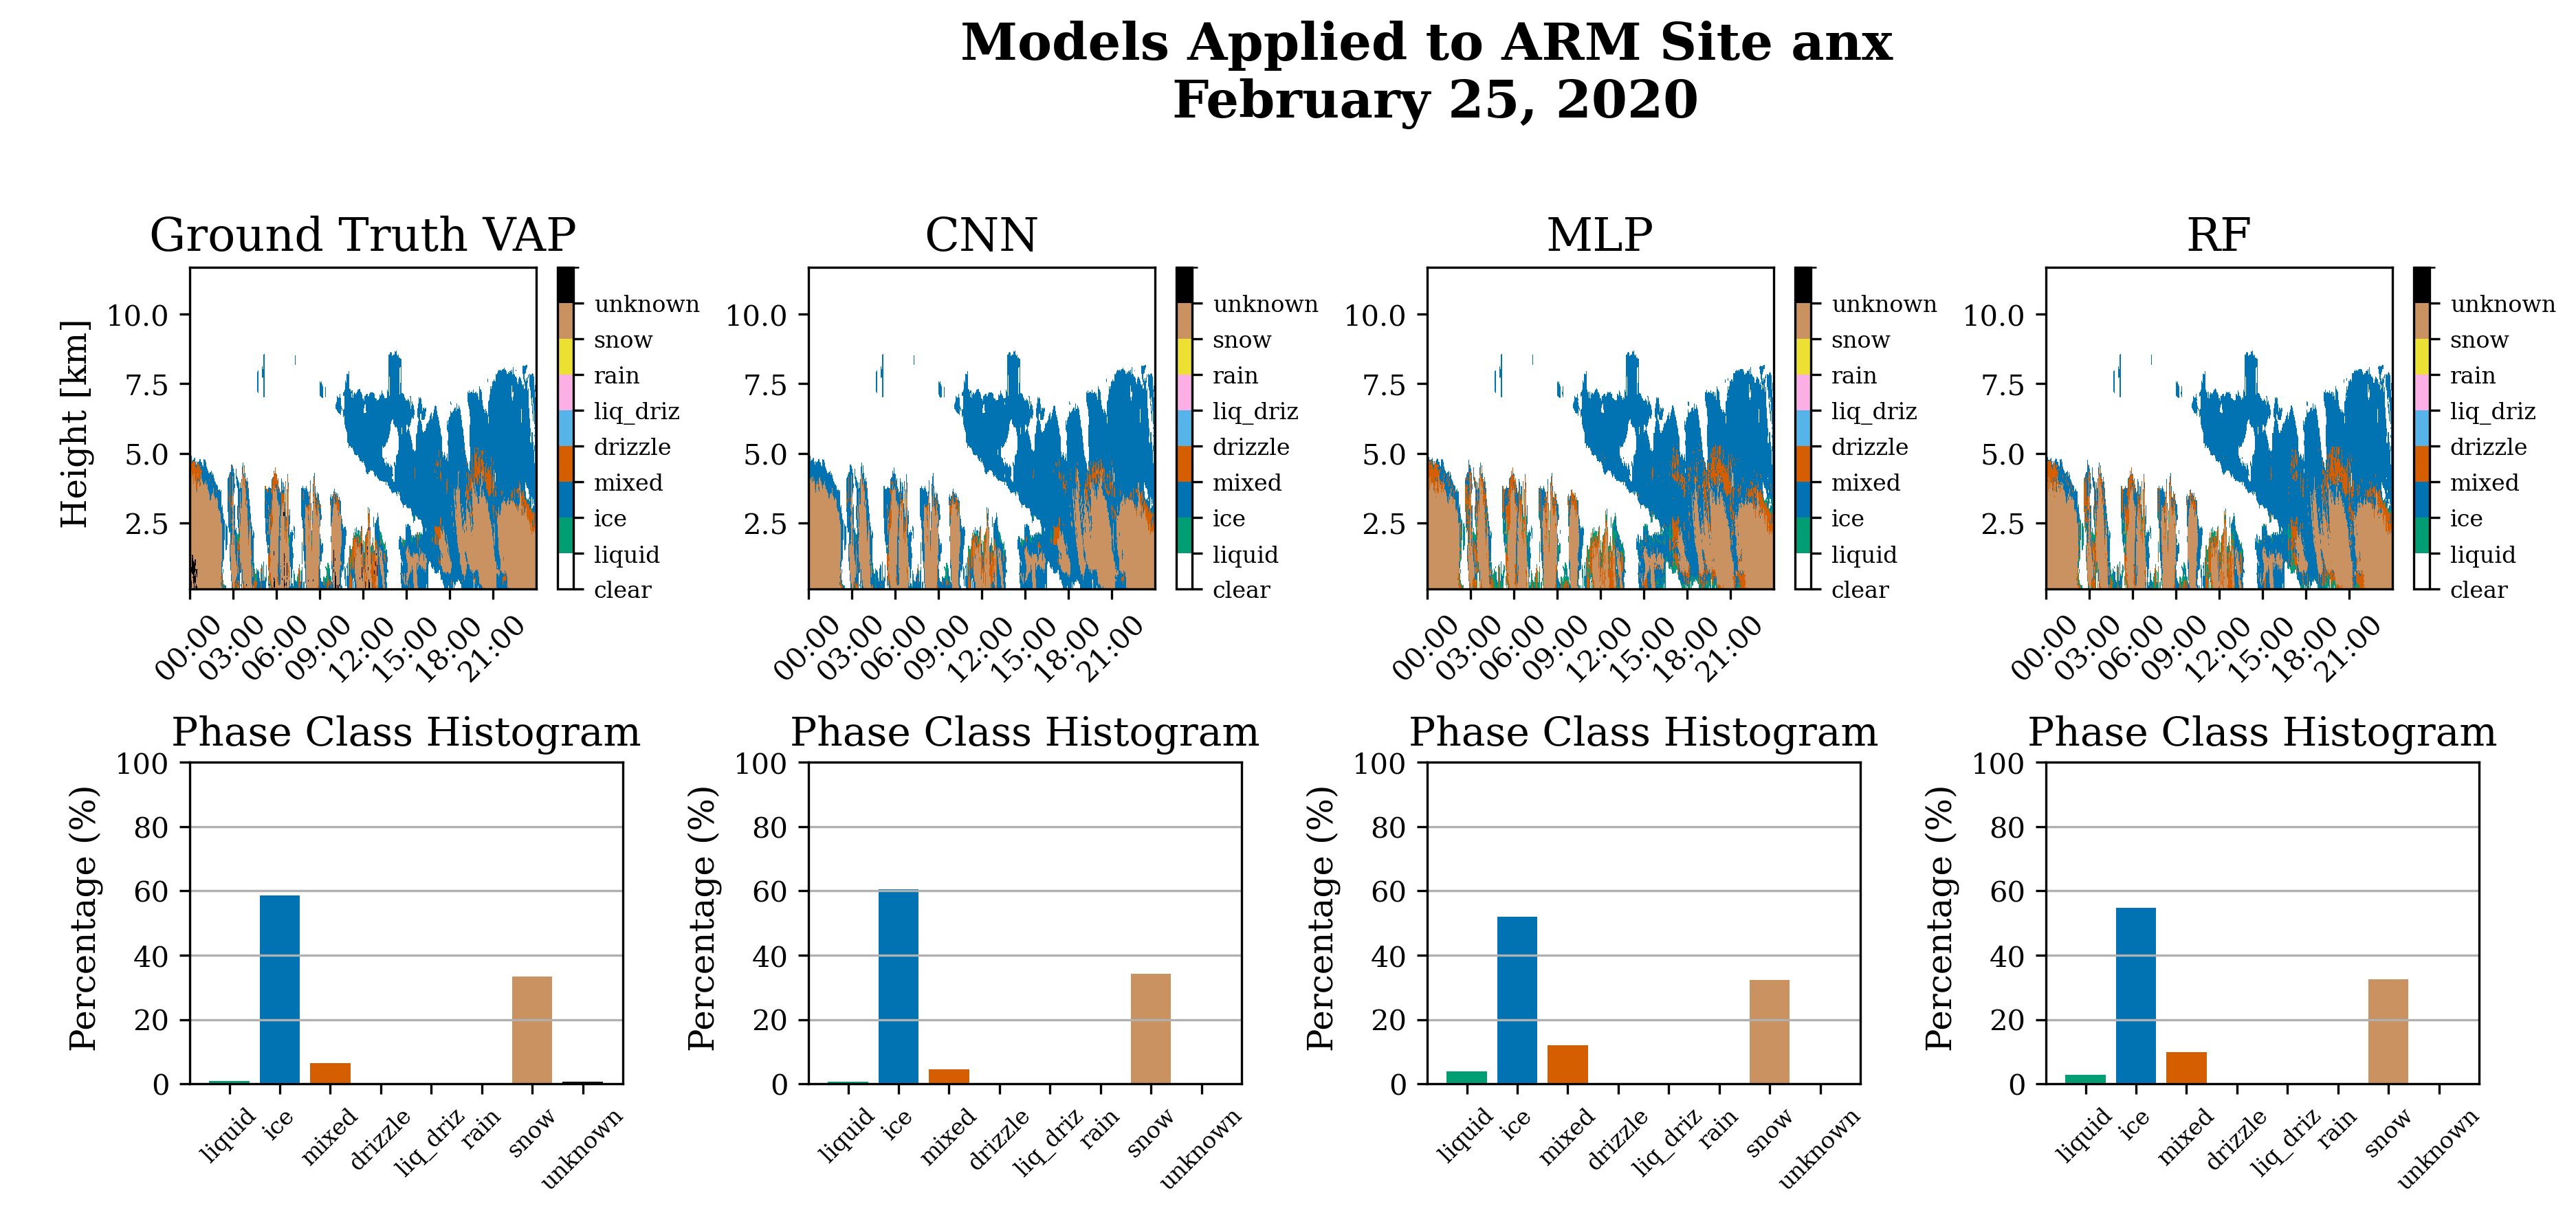

In [80]:

with plt.style.context("style.mplstyle"):
    # Create a figure
    fig = plt.figure(figsize=(15, 12))

    plt.suptitle('Models Applied to ARM Site ' + FILE_GLOB[0:3] + '\n ' + pd.to_datetime(ds.time[0].values).strftime('%B %d, %Y'), fontsize=18, fontweight='bold')

    # Create subplots
    axs = []
    for pos in positions[0:8]:
        ax = fig.add_axes(pos)  # Create an axes at the specified position
        axs.append(ax)

    # VAP Data
    create_timeseries('cloud_phase_mplgr',axs[0], ds, PHASE_MAP, custom_colors)
    create_histogram('cloud_phase_mplgr',axs[4], ds, PHASE_MAP, custom_colors)
    # CNN
    create_timeseries('cnn_20240501_090456',axs[1], ds, PHASE_MAP, custom_colors)
    create_histogram('cnn_20240501_090456',axs[5], ds, PHASE_MAP, custom_colors)
    # create_confidence_timeseries('cnn_20240501_090456_confidence', axs[8], ds)
    # create_matrix('cnn_20240501_090456',axs[11], ds, PHASE_MAP_small)
    # MLP
    create_timeseries('mlp_1600k_20240514_052837',axs[2], ds, PHASE_MAP, custom_colors)
    create_histogram('mlp_1600k_20240514_052837',axs[6], ds, PHASE_MAP, custom_colors)
    # create_confidence_timeseries('mlp_1600k_20240514_052837_confidence', axs[9], ds)
    # create_matrix('mlp_1600k_20240514_052837',axs[12], ds, PHASE_MAP_small)
    # RF
    create_timeseries('rf_1600k_20240514_033147',axs[3], ds, PHASE_MAP, custom_colors)
    create_histogram('rf_1600k_20240514_033147',axs[7], ds, PHASE_MAP, custom_colors)
    # create_confidence_timeseries('rf_1600k_20240514_033147_confidence', axs[10], ds)
    # create_matrix('rf_1600k_20240514_033147',axs[13], ds, PHASE_MAP_small)

    fig.savefig('figure_7.png')    
    plt.show()


#### Figure 8

In [81]:
FILE_GLOB = "nsathermocldphaseC1.c1.20210905.000000.nc"

# Construct the full file path
file_path = BASE_PATH / FILE_GLOB

# Open the NetCDF file with xarray
ds = xr.open_dataset(file_path)

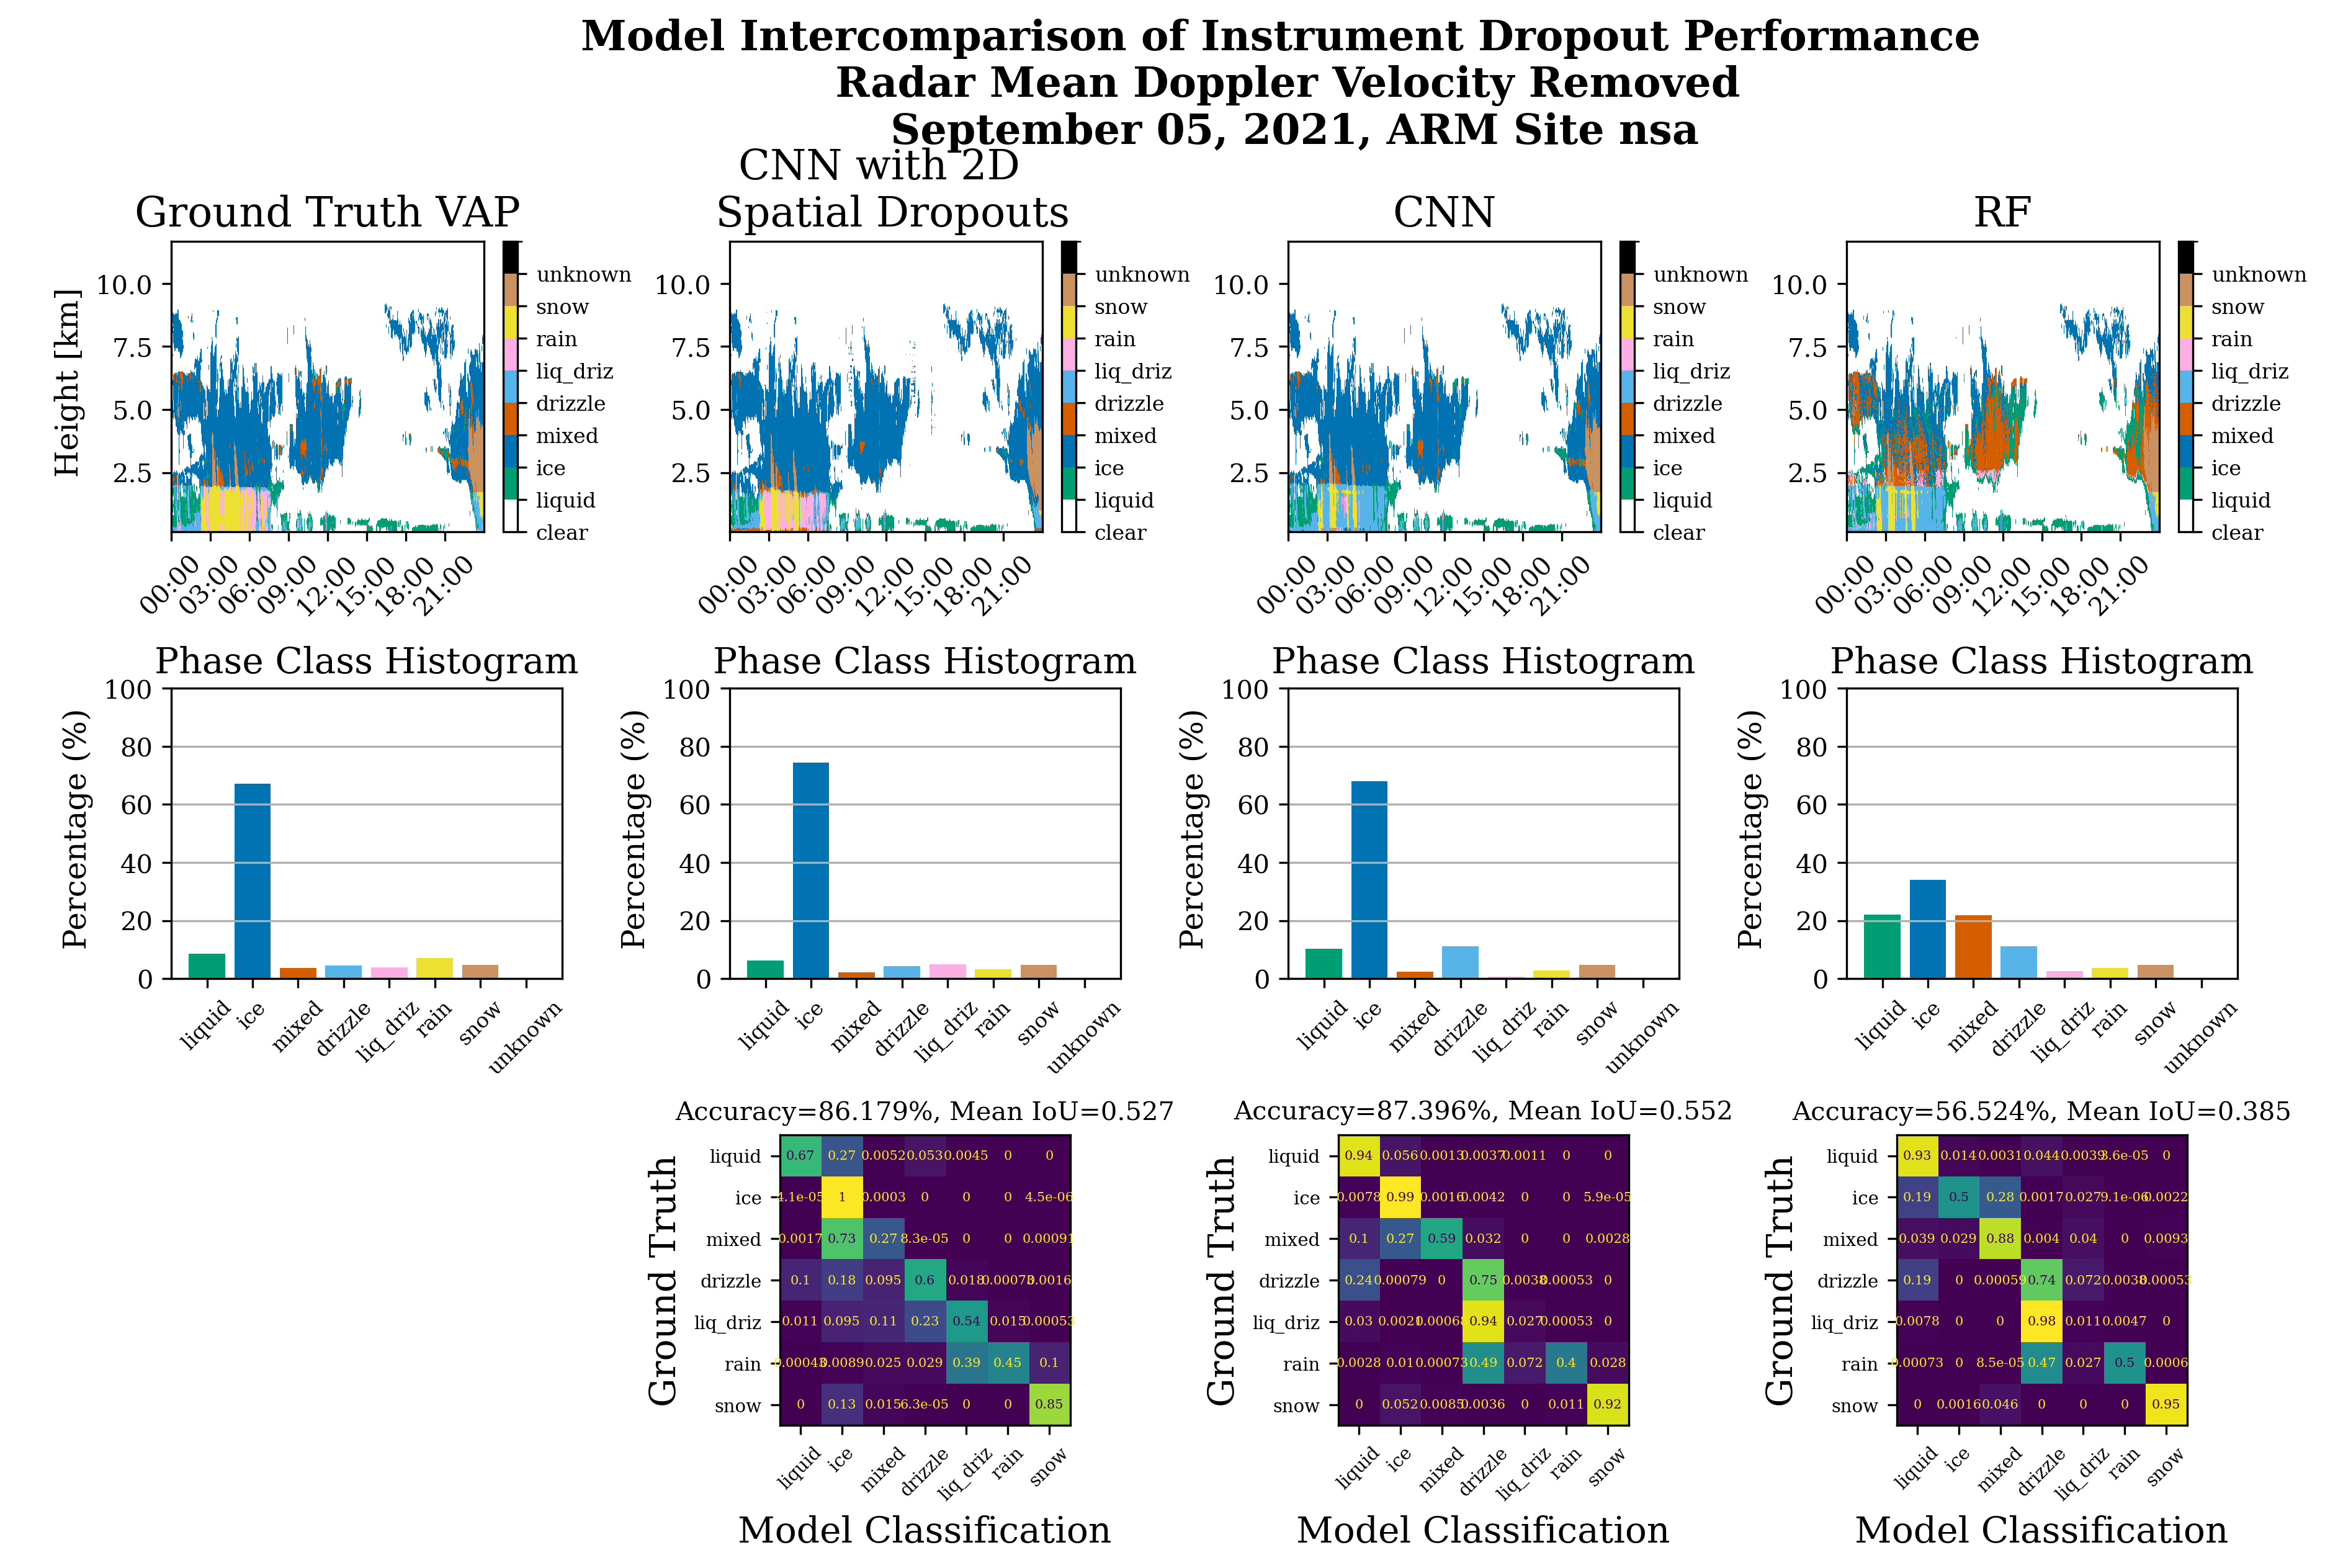

In [82]:

with plt.style.context("style.mplstyle"):
    # Create a figure
    fig = plt.figure(figsize=(15, 12))

    plt.suptitle('Model Intercomparison of Instrument Dropout Performance \n Radar Mean Doppler Velocity Removed \n ' + pd.to_datetime(ds.time[0].values).strftime('%B %d, %Y') + ', ARM Site ' + FILE_GLOB[0:3], fontsize=16, fontweight='bold')

    # Create subplots
    axs = []
    for pos in positions[0:11]:
        ax = fig.add_axes(pos)  # Create an axes at the specified position
        axs.append(ax)

    dropout = '_rad_mdv'

    # VAP Data
    create_timeseries('cloud_phase_mplgr',axs[0], ds, PHASE_MAP, custom_colors)
    create_histogram('cloud_phase_mplgr',axs[4], ds, PHASE_MAP, custom_colors)
    # CNN with dropouts
    create_timeseries('cnn_20240429_213223' + dropout,axs[1], ds, PHASE_MAP, custom_colors)
    create_histogram('cnn_20240429_213223' + dropout,axs[5], ds, PHASE_MAP, custom_colors)
    create_matrix('cnn_20240429_213223' + dropout,axs[8], ds, PHASE_MAP_small)
    # CNN
    create_timeseries('cnn_20240501_090456' + dropout,axs[2], ds, PHASE_MAP, custom_colors)
    create_histogram('cnn_20240501_090456' + dropout,axs[6], ds, PHASE_MAP, custom_colors)
    create_matrix('cnn_20240501_090456' + dropout,axs[9], ds, PHASE_MAP_small)
    # RF
    create_timeseries('rf_1600k_20240514_033147' + dropout,axs[3], ds, PHASE_MAP, custom_colors)
    create_histogram('rf_1600k_20240514_033147' + dropout,axs[7], ds, PHASE_MAP, custom_colors)
    create_matrix('rf_1600k_20240514_033147' + dropout,axs[10], ds, PHASE_MAP_small)

    fig.savefig('figure_8.png')    
    plt.show()


#### Figure 9

In [99]:
positions3 = [
    # Row 1 Time Series
    [col1, start_height +  heights * 3, width, height],   # Subplot 0
    [col2, start_height +  heights * 3, width, height],   # Subplot 1
    [col3, start_height +  heights * 3, width, height],   # Subplot 2
    [col4, start_height +  heights * 3, width, height],   # Subplot 3
    # Row 2 Histogram
    [col1, start_height +  heights * 2, width, height],  # Subplot 4
    [col2, start_height +  heights * 2, width, height],  # Subplot 5
    [col3, start_height +  heights * 2, width, height],  # Subplot 6
    [col4, start_height +  heights * 2, width, height],  # Subplot 7
    # Row 3 Confidence Time Series
    [col1, start_height +  heights * 1, width, height],   # Subplot 8
    [col2, start_height +  heights * 1, width, height],   # Subplot 9
    [col3, start_height +  heights * 1, width, height],  # Subplot 10
    [col4, start_height +  heights * 1, width, height],   # Subplot 11
    # Row 4 Matrix
    [col1, start_height, width, height],  # Subplot 12
    [col2, start_height, width, height],  # Subplot 13
    [col3, start_height, width, height],  # Subplot 14
    [col4, start_height, width, height],  # Subplot 15
]

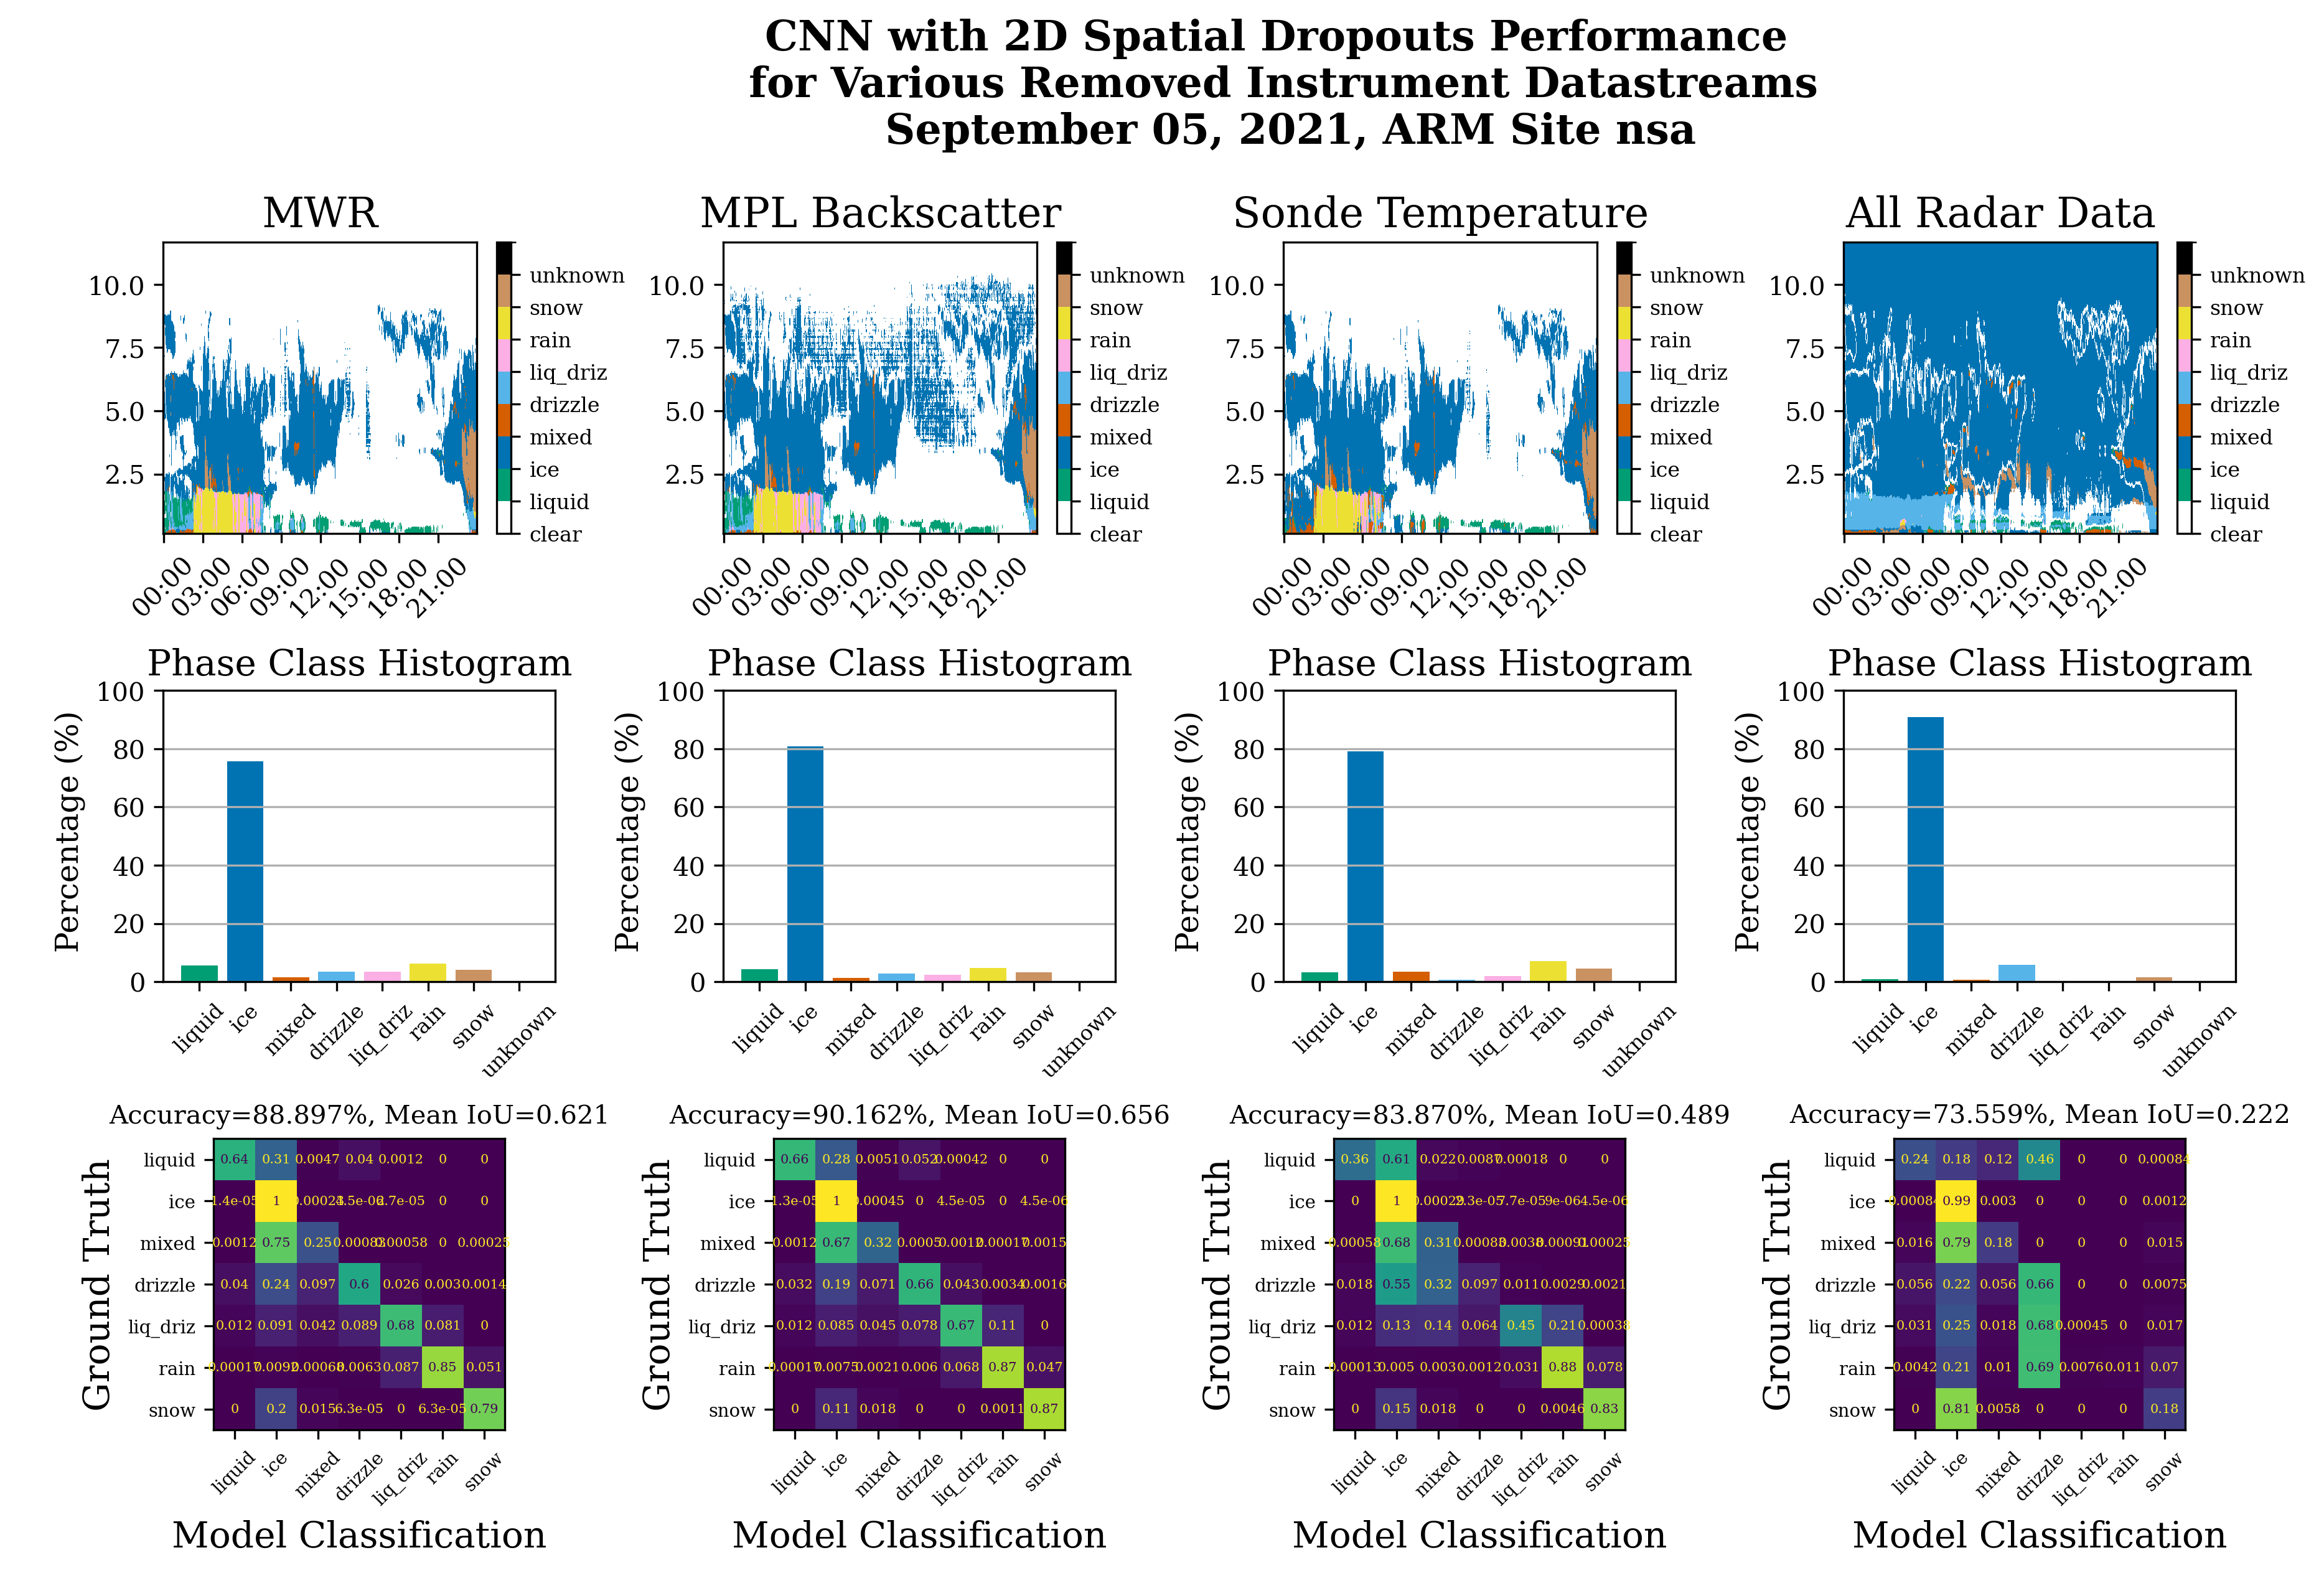

<Figure size 6000x4800 with 0 Axes>

In [85]:

with plt.style.context("style.mplstyle"):
    # Create a figure
    fig = plt.figure(figsize=(15, 12))

    plt.suptitle('CNN with 2D Spatial Dropouts Performance \n for Various Removed Instrument Datastreams \n ' + pd.to_datetime(ds.time[0].values).strftime('%B %d, %Y') + ', ARM Site ' + FILE_GLOB[0:3], fontsize=16, fontweight='bold')
    plt.figure(facecolor='white')
    # Create subplots
    axs = []
    for pos in positions3[0:12]:
        ax = fig.add_axes(pos)  # Create an axes at the specified position
        axs.append(ax)

    # CNN with Dropout
    dropout = '_mwr'
    create_timeseries('cnn_20240429_213223' + dropout,axs[0], ds, PHASE_MAP, custom_colors)
    create_histogram('cnn_20240429_213223' + dropout,axs[4], ds, PHASE_MAP, custom_colors)
    create_matrix('cnn_20240429_213223' + dropout,axs[8], ds, PHASE_MAP_small)
    #
    dropout = '_mpl_ldr'
    create_timeseries('cnn_20240429_213223' + dropout,axs[1], ds, PHASE_MAP, custom_colors)
    create_histogram('cnn_20240429_213223' + dropout,axs[5], ds, PHASE_MAP, custom_colors)
    create_matrix('cnn_20240429_213223' + dropout,axs[9], ds, PHASE_MAP_small)
    #
    dropout = '_sonde'
    create_timeseries('cnn_20240429_213223' + dropout,axs[2], ds, PHASE_MAP, custom_colors)
    create_histogram('cnn_20240429_213223' + dropout,axs[6], ds, PHASE_MAP, custom_colors)
    create_matrix('cnn_20240429_213223' + dropout,axs[10], ds, PHASE_MAP_small)
    #
    dropout = '_rad'
    create_timeseries('cnn_20240429_213223' + dropout,axs[3], ds, PHASE_MAP, custom_colors)
    create_histogram('cnn_20240429_213223' + dropout,axs[7], ds, PHASE_MAP, custom_colors)
    create_matrix('cnn_20240429_213223' + dropout,axs[11], ds, PHASE_MAP_small)

    axs[0].set_title('MWR', fontsize = 16)
    axs[1].set_title('MPL Backscatter', fontsize = 16)
    axs[2].set_title('Sonde Temperature', fontsize = 16)
    axs[3].set_title('All Radar Data', fontsize = 16)

    fig.savefig('figure_9.png')    
    plt.show()


# Figures 8&9 Alternatives

In [95]:
FILE_GLOB = "nsathermocldphaseC1.c1.20210815.000000.nc"

# Construct the full file path
file_path = BASE_PATH / FILE_GLOB

# Open the NetCDF file with xarray
ds = xr.open_dataset(file_path)

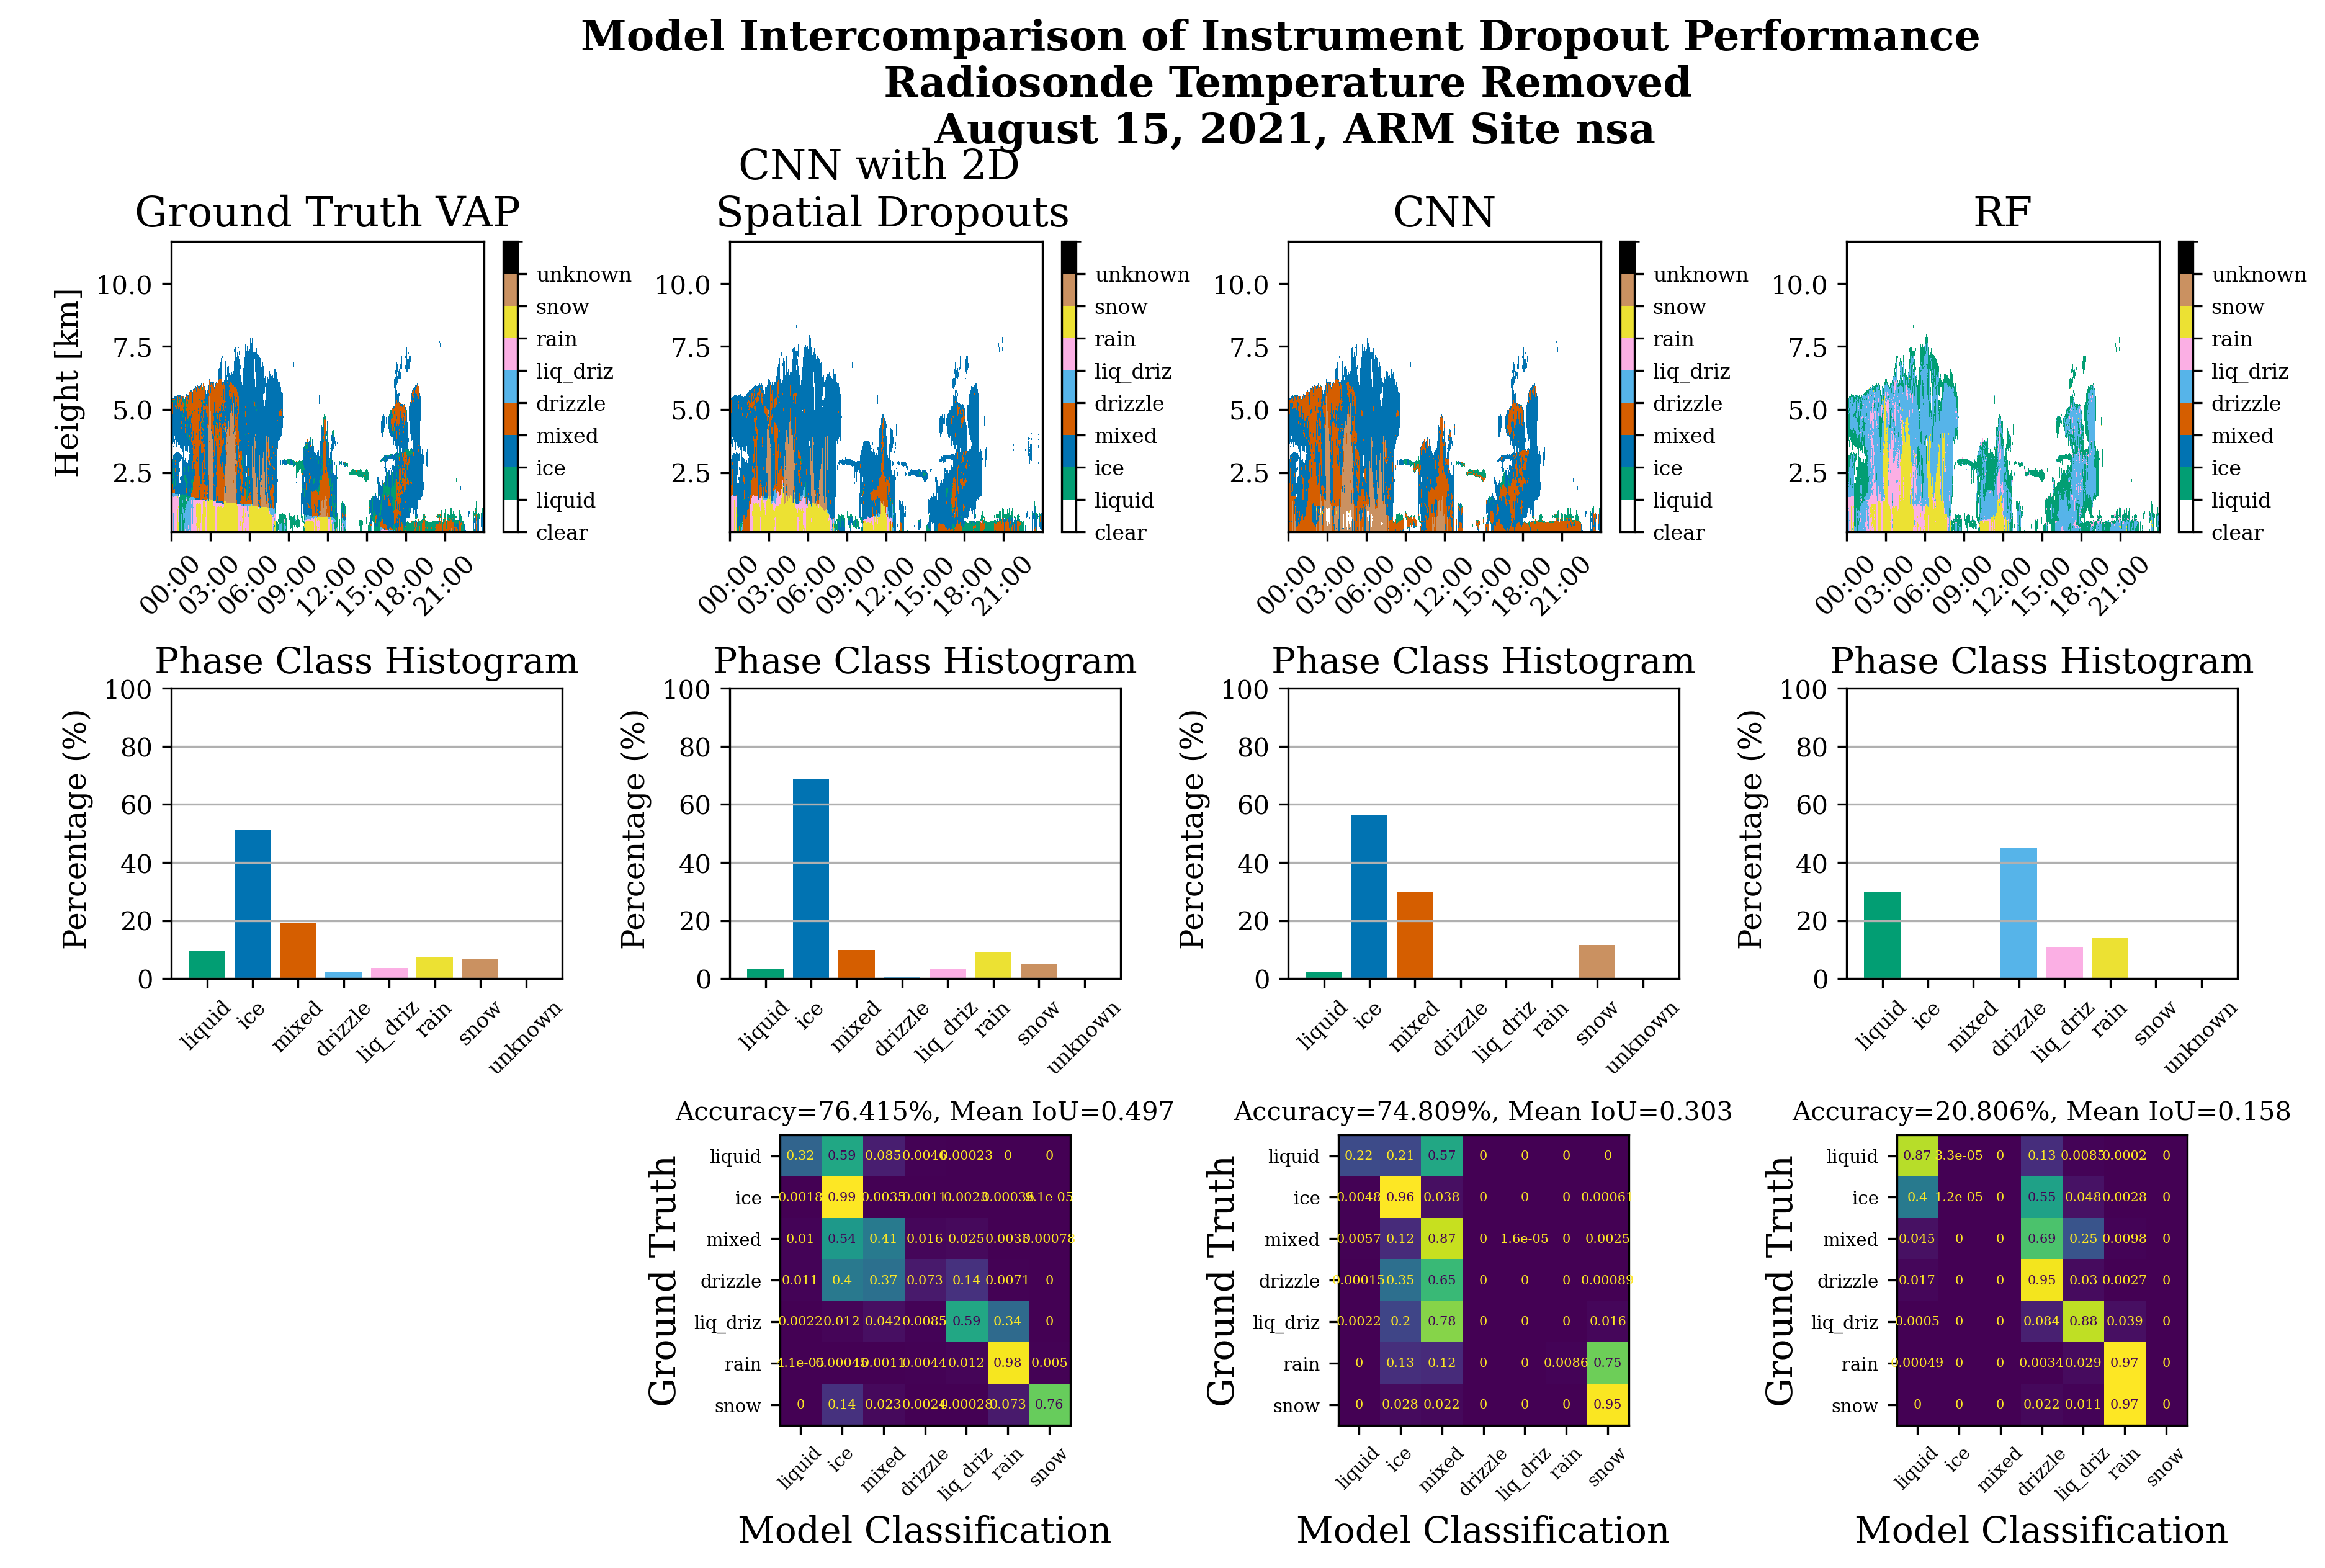

In [101]:

with plt.style.context("style.mplstyle"):
    # Create a figure
    fig = plt.figure(figsize=(15, 12))

    plt.suptitle('Model Intercomparison of Instrument Dropout Performance \n Radiosonde Temperature Removed \n ' + pd.to_datetime(ds.time[0].values).strftime('%B %d, %Y') + ', ARM Site ' + FILE_GLOB[0:3], fontsize=16, fontweight='bold')

    # Create subplots
    axs = []
    for pos in positions[0:11]:
        ax = fig.add_axes(pos)  # Create an axes at the specified position
        axs.append(ax)

    dropout = '_sonde'

    # VAP Data
    create_timeseries('cloud_phase_mplgr',axs[0], ds, PHASE_MAP, custom_colors)
    create_histogram('cloud_phase_mplgr',axs[4], ds, PHASE_MAP, custom_colors)
    # CNN with dropouts
    create_timeseries('cnn_20240429_213223' + dropout,axs[1], ds, PHASE_MAP, custom_colors)
    create_histogram('cnn_20240429_213223' + dropout,axs[5], ds, PHASE_MAP, custom_colors)
    create_matrix('cnn_20240429_213223' + dropout,axs[8], ds, PHASE_MAP_small)
    # CNN
    create_timeseries('cnn_20240501_090456' + dropout,axs[2], ds, PHASE_MAP, custom_colors)
    create_histogram('cnn_20240501_090456' + dropout,axs[6], ds, PHASE_MAP, custom_colors)
    create_matrix('cnn_20240501_090456' + dropout,axs[9], ds, PHASE_MAP_small)
    # RF
    create_timeseries('rf_1600k_20240514_033147' + dropout,axs[3], ds, PHASE_MAP, custom_colors)
    create_histogram('rf_1600k_20240514_033147' + dropout,axs[7], ds, PHASE_MAP, custom_colors)
    create_matrix('rf_1600k_20240514_033147' + dropout,axs[10], ds, PHASE_MAP_small)

    fig.savefig('figure_8_alt.png')    
    plt.show()


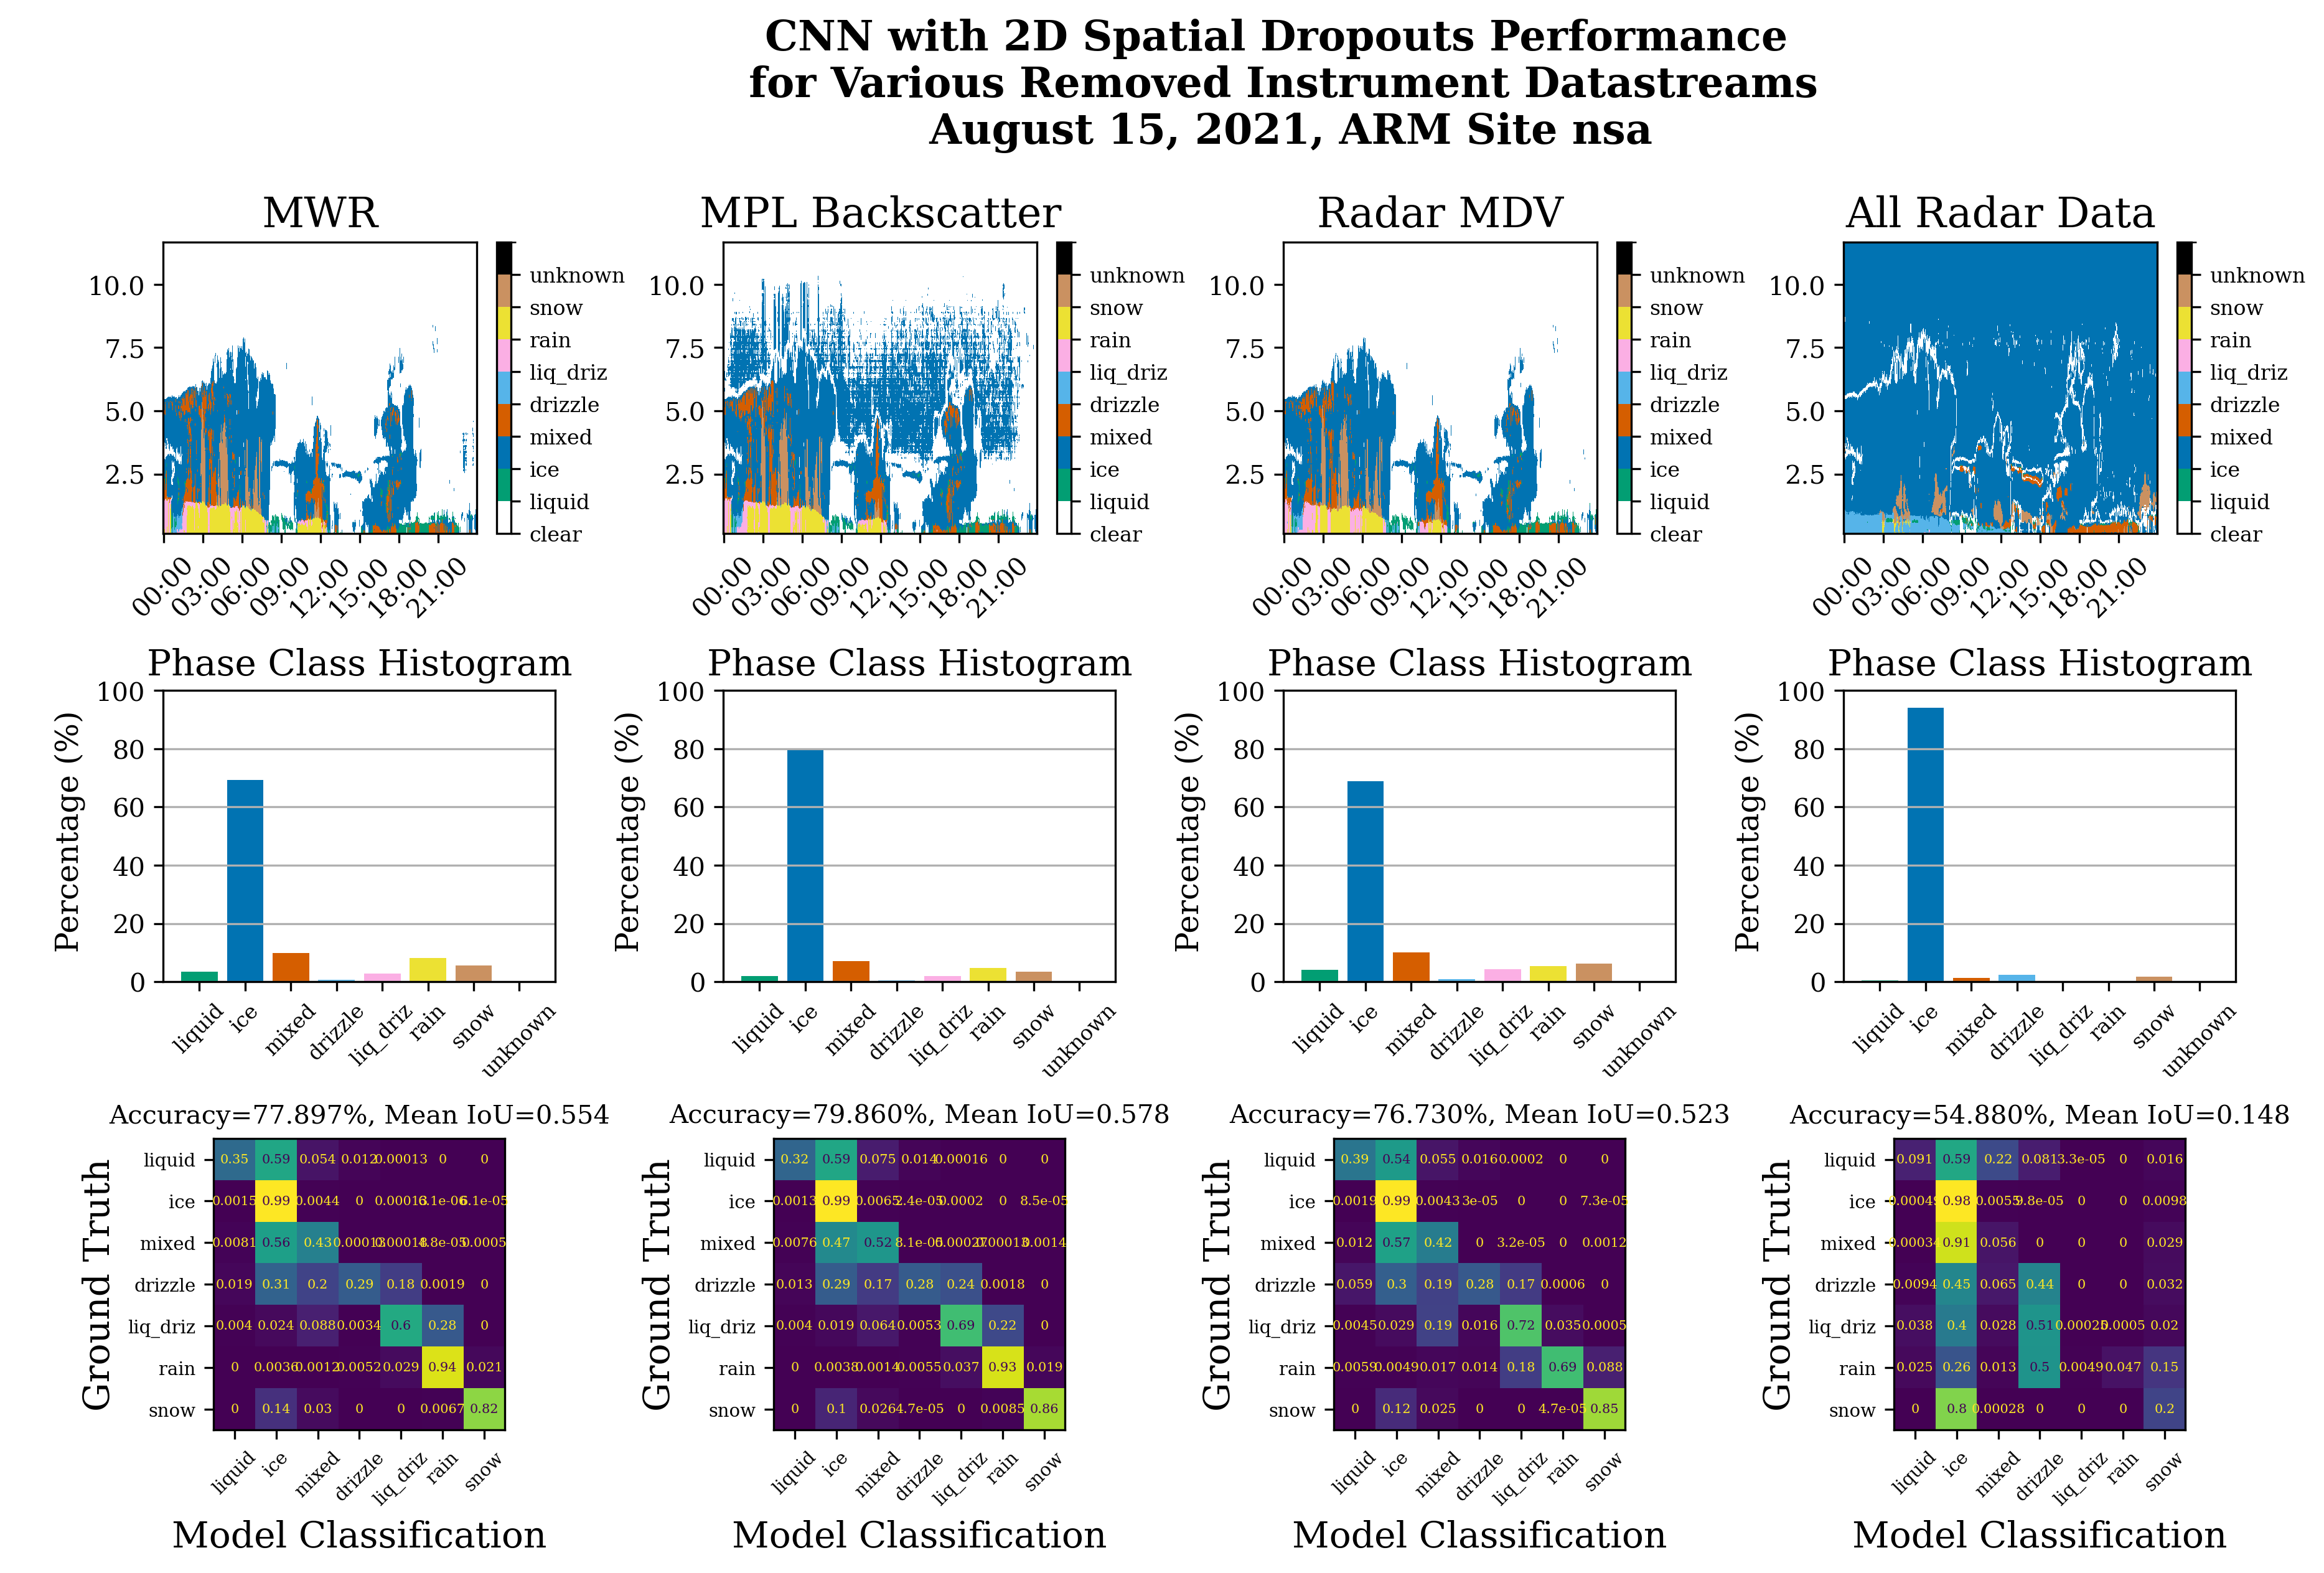

<Figure size 6000x4800 with 0 Axes>

In [100]:

with plt.style.context("style.mplstyle"):
    # Create a figure
    fig = plt.figure(figsize=(15, 12))

    plt.suptitle('CNN with 2D Spatial Dropouts Performance \n for Various Removed Instrument Datastreams \n ' + pd.to_datetime(ds.time[0].values).strftime('%B %d, %Y') + ', ARM Site ' + FILE_GLOB[0:3], fontsize=16, fontweight='bold')
    plt.figure(facecolor='white')
    # Create subplots
    axs = []
    for pos in positions3[0:12]:
        ax = fig.add_axes(pos)  # Create an axes at the specified position
        axs.append(ax)

    # CNN with Dropout
    dropout = '_mwr'
    create_timeseries('cnn_20240429_213223' + dropout,axs[0], ds, PHASE_MAP, custom_colors)
    create_histogram('cnn_20240429_213223' + dropout,axs[4], ds, PHASE_MAP, custom_colors)
    create_matrix('cnn_20240429_213223' + dropout,axs[8], ds, PHASE_MAP_small)
    #
    dropout = '_mpl_b'
    create_timeseries('cnn_20240429_213223' + dropout,axs[1], ds, PHASE_MAP, custom_colors)
    create_histogram('cnn_20240429_213223' + dropout,axs[5], ds, PHASE_MAP, custom_colors)
    create_matrix('cnn_20240429_213223' + dropout,axs[9], ds, PHASE_MAP_small)
    #
    dropout = '_rad_mdv'
    create_timeseries('cnn_20240429_213223' + dropout,axs[2], ds, PHASE_MAP, custom_colors)
    create_histogram('cnn_20240429_213223' + dropout,axs[6], ds, PHASE_MAP, custom_colors)
    create_matrix('cnn_20240429_213223' + dropout,axs[10], ds, PHASE_MAP_small)
    #
    dropout = '_rad'
    create_timeseries('cnn_20240429_213223' + dropout,axs[3], ds, PHASE_MAP, custom_colors)
    create_histogram('cnn_20240429_213223' + dropout,axs[7], ds, PHASE_MAP, custom_colors)
    create_matrix('cnn_20240429_213223' + dropout,axs[11], ds, PHASE_MAP_small)

    axs[0].set_title('MWR', fontsize = 16)
    axs[1].set_title('MPL Backscatter', fontsize = 16)
    axs[2].set_title('Radar MDV', fontsize = 16)
    axs[3].set_title('All Radar Data', fontsize = 16)

    fig.savefig('figure_9_alt.png')    
    plt.show()
